In [1]:
# Choose basedir as either local or hosted directory
import os
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [2]:


import time
import platform
import tqdm
import torch
import torch.nn as nn
import torchvision
import numpy as np
import subprocess
import random
import imgaug as ia


def provide_determinism(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    ia.seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


def worker_seed_set(worker_id):
    # See for details of numpy:
    # https://github.com/pytorch/pytorch/issues/5059#issuecomment-817392562
    # See for details of random:
    # https://pytorch.org/docs/stable/notes/randomness.html#dataloader

    # NumPy
    uint64_seed = torch.initial_seed()
    ss = np.random.SeedSequence([uint64_seed])
    np.random.seed(ss.generate_state(4))

    # random
    worker_seed = torch.initial_seed() % 2**32
    random.seed(worker_seed)


def to_cpu(tensor):
    return tensor.detach().cpu()


def load_classes(path):
    """
    Loads class labels at 'path'
    """
    with open(path, "r") as fp:
        names = fp.read().splitlines()
    return names


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)


def rescale_boxes(boxes, current_dim, original_shape):
    """
    Rescales bounding boxes to the original shape
    """
    orig_h, orig_w = original_shape

    # The amount of padding that was added
    pad_x = max(orig_h - orig_w, 0) * (current_dim / max(original_shape))
    pad_y = max(orig_w - orig_h, 0) * (current_dim / max(original_shape))

    # Image height and width after padding is removed
    unpad_h = current_dim - pad_y
    unpad_w = current_dim - pad_x

    # Rescale bounding boxes to dimension of original image
    boxes[:, 0] = ((boxes[:, 0] - pad_x // 2) / unpad_w) * orig_w
    boxes[:, 1] = ((boxes[:, 1] - pad_y // 2) / unpad_h) * orig_h
    boxes[:, 2] = ((boxes[:, 2] - pad_x // 2) / unpad_w) * orig_w
    boxes[:, 3] = ((boxes[:, 3] - pad_y // 2) / unpad_h) * orig_h
    return boxes


def xywh2xyxy(x):
    y = x.new(x.shape)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y


def xywh2xyxy_np(x):
    y = np.zeros_like(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y


def ap_per_class(tp, conf, pred_cls, target_cls):
    """ Compute the average precision, given the recall and precision curves.
    Source: https://github.com/rafaelpadilla/Object-Detection-Metrics.
    # Arguments
        tp:    True positives (list).
        conf:  Objectness value from 0-1 (list).
        pred_cls: Predicted object classes (list).
        target_cls: True object classes (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """

    # Sort by objectness
    i = np.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # Find unique classes
    unique_classes = np.unique(target_cls)

    # Create Precision-Recall curve and compute AP for each class
    ap, p, r = [], [], []
    for c in tqdm.tqdm(unique_classes, desc="Computing AP"):
        i = pred_cls == c
        n_gt = (target_cls == c).sum()  # Number of ground truth objects
        n_p = i.sum()  # Number of predicted objects

        if n_p == 0 and n_gt == 0:
            continue
        elif n_p == 0 or n_gt == 0:
            ap.append(0)
            r.append(0)
            p.append(0)
        else:
            # Accumulate FPs and TPs
            fpc = (1 - tp[i]).cumsum()
            tpc = (tp[i]).cumsum()

            # Recall
            recall_curve = tpc / (n_gt + 1e-16)
            r.append(recall_curve[-1])

            # Precision
            precision_curve = tpc / (tpc + fpc)
            p.append(precision_curve[-1])

            # AP from recall-precision curve
            ap.append(compute_ap(recall_curve, precision_curve))

    # Compute F1 score (harmonic mean of precision and recall)
    p, r, ap = np.array(p), np.array(r), np.array(ap)
    f1 = 2 * p * r / (p + r + 1e-16)

    return p, r, ap, f1, unique_classes.astype("int32")


def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.

    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap


def get_batch_statistics(outputs, targets, iou_threshold):
    """ Compute true positives, predicted scores and predicted labels per sample """
    batch_metrics = []
    for sample_i in range(len(outputs)):

        if outputs[sample_i] is None:
            continue

        output = outputs[sample_i]
        pred_boxes = output[:, :4]
        pred_scores = output[:, 4]
        pred_labels = output[:, -1]

        true_positives = np.zeros(pred_boxes.shape[0])

        annotations = targets[targets[:, 0] == sample_i][:, 1:]
        target_labels = annotations[:, 0] if len(annotations) else []
        if len(annotations):
            detected_boxes = []
            target_boxes = annotations[:, 1:]

            for pred_i, (pred_box, pred_label) in enumerate(zip(pred_boxes, pred_labels)):

                # If targets are found break
                if len(detected_boxes) == len(annotations):
                    break

                # Ignore if label is not one of the target labels
                if pred_label not in target_labels:
                    continue

                # Filter target_boxes by pred_label so that we only match against boxes of our own label
                filtered_target_position, filtered_targets = zip(*filter(lambda x: target_labels[x[0]] == pred_label, enumerate(target_boxes)))

                # Find the best matching target for our predicted box
                iou, box_filtered_index = bbox_iou(pred_box.unsqueeze(0).T, torch.stack(filtered_targets)).max(0)

                # Remap the index in the list of filtered targets for that label to the index in the list with all targets.
                box_index = filtered_target_position[box_filtered_index]

                # Check if the iou is above the min treshold and i
                if iou >= iou_threshold and box_index not in detected_boxes:
                    true_positives[pred_i] = 1
                    detected_boxes += [box_index]
        batch_metrics.append([true_positives, pred_scores, pred_labels])
    return batch_metrics


def bbox_wh_iou(wh1, wh2):
    wh2 = wh2.t()
    w1, h1 = wh1[0], wh1[1]
    w2, h2 = wh2[0], wh2[1]
    inter_area = torch.min(w1, w2) * torch.min(h1, h2)
    union_area = (w1 * h1 + 1e-16) + w2 * h2 - inter_area
    return inter_area / union_area


def box_iou(box1, box2):
    # https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py
    """
    Return intersection-over-union (Jaccard index) of boxes.
    Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
    Arguments:
        box1 (Tensor[N, 4])
        box2 (Tensor[M, 4])
    Returns:
        iou (Tensor[N, M]): the NxM matrix containing the pairwise
            IoU values for every element in boxes1 and boxes2
    """

    def box_area(box):
        # box = 4xn
        return (box[2] - box[0]) * (box[3] - box[1])

    area1 = box_area(box1.T)
    area2 = box_area(box2.T)

    # inter(N,M) = (rb(N,M,2) - lt(N,M,2)).clamp(0).prod(2)
    inter = (torch.min(box1[:, None, 2:], box2[:, 2:]) -
             torch.max(box1[:, None, :2], box2[:, :2])).clamp(0).prod(2)
    # iou = inter / (area1 + area2 - inter)
    return inter / (area1[:, None] + area2 - inter)


def non_max_suppression(prediction, conf_thres=0.25, iou_thres=0.45, classes=None):
    """Performs Non-Maximum Suppression (NMS) on inference results
    Returns:
         detections with shape: nx6 (x1, y1, x2, y2, conf, cls)
    """

    nc = prediction.shape[2] - 5  # number of classes

    # Settings
    # (pixels) minimum and maximum box width and height
    max_wh = 4096
    max_det = 300  # maximum number of detections per image
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
    time_limit = 1.0  # seconds to quit after
    multi_label = nc > 1  # multiple labels per box (adds 0.5ms/img)

    t = time.time()
    output = [torch.zeros((0, 6), device="cpu")] * prediction.shape[0]

    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
        x = x[x[..., 4] > conf_thres]  # confidence

        # If none remain process next image
        if not x.shape[0]:
            continue

        # Compute conf
        x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

        # Box (center x, center y, width, height) to (x1, y1, x2, y2)
        box = xywh2xyxy(x[:, :4])

        # Detections matrix nx6 (xyxy, conf, cls)
        if multi_label:
            i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
        else:  # best class only
            conf, j = x[:, 5:].max(1, keepdim=True)
            x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]

        # Filter by class
        if classes is not None:
            x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        elif n > max_nms:  # excess boxes
            # sort by confidence
            x = x[x[:, 4].argsort(descending=True)[:max_nms]]

        # Batched NMS
        c = x[:, 5:6] * max_wh  # classes
        # boxes (offset by class), scores
        boxes, scores = x[:, :4] + c, x[:, 4]
        i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
        if i.shape[0] > max_det:  # limit detections
            i = i[:max_det]

        output[xi] = to_cpu(x[i])

        if (time.time() - t) > time_limit:
            print(f'WARNING: NMS time limit {time_limit}s exceeded')
            break  # time limit exceeded

    return output


def print_environment_info():
    """
    Prints infos about the environment and the system.
    This should help when people make issues containg the printout.
    """

    print("Environment information:")

    # Print OS information
    print(f"System: {platform.system()} {platform.release()}")

    # Print poetry package version
    try:
        print(f"Current Version: {subprocess.check_output(['poetry', 'version'], stderr=subprocess.DEVNULL).decode('ascii').strip()}")
    except (subprocess.CalledProcessError, FileNotFoundError):
        print("Not using the poetry package")

    # Print commit hash if possible
    try:
        print(f"Current Commit Hash: {subprocess.check_output(['git', 'rev-parse', '--short', 'HEAD'], stderr=subprocess.DEVNULL).decode('ascii').strip()}")
    except (subprocess.CalledProcessError, FileNotFoundError):
        print("No git or repo found")


In [3]:
import torch
import torch.nn.functional as F
import numpy as np

import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

import torchvision.transforms as transforms


class ImgAug(object):
    def __init__(self, augmentations=[]):
        self.augmentations = augmentations

    def __call__(self, data):
        # Unpack data
        img, boxes = data

        # Convert xywh to xyxy
        boxes = np.array(boxes)
        boxes[:, 1:] = xywh2xyxy_np(boxes[:, 1:])

        # Convert bounding boxes to imgaug
        bounding_boxes = BoundingBoxesOnImage(
            [BoundingBox(*box[1:], label=box[0]) for box in boxes],
            shape=img.shape)

        # Apply augmentations
        img, bounding_boxes = self.augmentations(
            image=img,
            bounding_boxes=bounding_boxes)

        # Clip out of image boxes
        bounding_boxes = bounding_boxes.clip_out_of_image()

        # Convert bounding boxes back to numpy
        boxes = np.zeros((len(bounding_boxes), 5))
        for box_idx, box in enumerate(bounding_boxes):
            # Extract coordinates for unpadded + unscaled image
            x1 = box.x1
            y1 = box.y1
            x2 = box.x2
            y2 = box.y2

            # Returns (x, y, w, h)
            boxes[box_idx, 0] = box.label
            boxes[box_idx, 1] = ((x1 + x2) / 2)
            boxes[box_idx, 2] = ((y1 + y2) / 2)
            boxes[box_idx, 3] = (x2 - x1)
            boxes[box_idx, 4] = (y2 - y1)

        return img, boxes


class RelativeLabels(object):
    def __init__(self, ):
        pass

    def __call__(self, data):
        img, boxes = data
        h, w, _ = img.shape
        boxes[:, [1, 3]] /= w
        boxes[:, [2, 4]] /= h
        return img, boxes


class AbsoluteLabels(object):
    def __init__(self, ):
        pass

    def __call__(self, data):
        img, boxes = data
        h, w, _ = img.shape
        boxes[:, [1, 3]] *= w
        boxes[:, [2, 4]] *= h
        return img, boxes


class PadSquare(ImgAug):
    def __init__(self, ):
        self.augmentations = iaa.Sequential([
            iaa.PadToAspectRatio(
                1.0,
                position="center-center").to_deterministic()
        ])


class ToTensor(object):
    def __init__(self, ):
        pass

    def __call__(self, data):
        img, boxes = data
        # Extract image as PyTorch tensor
        img = transforms.ToTensor()(img)

        bb_targets = torch.zeros((len(boxes), 6))
        bb_targets[:, 1:] = transforms.ToTensor()(boxes)

        return img, bb_targets


class Resize(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, data):
        img, boxes = data
        img = F.interpolate(img.unsqueeze(0), size=self.size, mode="nearest").squeeze(0)
        return img, boxes


DEFAULT_TRANSFORMS = transforms.Compose([
    AbsoluteLabels(),
    PadSquare(),
    RelativeLabels(),
    ToTensor(),
])


In [4]:
import os
import datetime
from torch.utils.tensorboard import SummaryWriter


class Logger(object):
    def __init__(self, log_dir, log_hist=True):
        """Create a summary writer logging to log_dir."""
        if log_hist:    # Check a new folder for each log should be dreated
            log_dir = os.path.join(
                log_dir,
                datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S"))
        self.writer = SummaryWriter(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        self.writer.add_scalar(tag, value, step)

    def list_of_scalars_summary(self, tag_value_pairs, step):
        """Log scalar variables."""
        for tag, value in tag_value_pairs:
            self.writer.add_scalar(tag, value, step)


In [5]:


def parse_model_config(path):
    """Parses the yolo-v3 layer configuration file and returns module definitions"""
    file = open(path, 'r')
    lines = file.read().split('\n')
    lines = [x for x in lines if x and not x.startswith('#')]
    lines = [x.rstrip().lstrip() for x in lines]  # get rid of fringe whitespaces
    module_defs = []
    for line in lines:
        if line.startswith('['):  # This marks the start of a new block
            module_defs.append({})
            module_defs[-1]['type'] = line[1:-1].rstrip()
            if module_defs[-1]['type'] == 'convolutional':
                module_defs[-1]['batch_normalize'] = 0
        else:
            key, value = line.split("=")
            value = value.strip()
            module_defs[-1][key.rstrip()] = value.strip()

    return module_defs


def parse_data_config(path):
    """Parses the data configuration file"""
    options = dict()
    options['gpus'] = '0,1,2,3'
    options['num_workers'] = '10'
    with open(path, 'r') as fp:
        lines = fp.readlines()
    for line in lines:
        line = line.strip()
        if line == '' or line.startswith('#'):
            continue
        key, value = line.split('=')
        options[key.strip()] = value.strip()
    return options


In [6]:

import math

import torch
import torch.nn as nn

# This new loss function is based on https://github.com/ultralytics/yolov3/blob/master/utils/loss.py


def bbox_iou(box1, box2, x1y1x2y2=False, GIoU=False, DIoU=False, CIoU=False, eps=1e-9):
    # Returns the IoU of box1 to box2. box1 is 4, box2 is nx4
    box2 = box2.T

    # Get the coordinates of bounding boxes
    if x1y1x2y2:  # x1, y1, x2, y2 = box1
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[0], box1[1], box1[2], box1[3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[0], box2[1], box2[2], box2[3]
    else:  # transform from xywh to xyxy
        b1_x1, b1_x2 = box1[0] - box1[2] / 2, box1[0] + box1[2] / 2
        b1_y1, b1_y2 = box1[1] - box1[3] / 2, box1[1] + box1[3] / 2
        b2_x1, b2_x2 = box2[0] - box2[2] / 2, box2[0] + box2[2] / 2
        b2_y1, b2_y2 = box2[1] - box2[3] / 2, box2[1] + box2[3] / 2

    # Intersection area
    inter = (torch.min(b1_x2, b2_x2) - torch.max(b1_x1, b2_x1)).clamp(0) * \
            (torch.min(b1_y2, b2_y2) - torch.max(b1_y1, b2_y1)).clamp(0)

    # Union Area
    w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1 + eps
    w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1 + eps
    union = w1 * h1 + w2 * h2 - inter + eps

    iou = inter / union
    if GIoU or DIoU or CIoU:
        # convex (smallest enclosing box) width
        cw = torch.max(b1_x2, b2_x2) - torch.min(b1_x1, b2_x1)
        ch = torch.max(b1_y2, b2_y2) - torch.min(b1_y1, b2_y1)  # convex height
        if CIoU or DIoU:  # Distance or Complete IoU https://arxiv.org/abs/1911.08287v1
            c2 = cw ** 2 + ch ** 2 + eps  # convex diagonal squared
            rho2 = ((b2_x1 + b2_x2 - b1_x1 - b1_x2) ** 2 +
                    (b2_y1 + b2_y2 - b1_y1 - b1_y2) ** 2) / 4  # center distance squared
            if DIoU:
                return iou - rho2 / c2  # DIoU
            elif CIoU:  # https://github.com/Zzh-tju/DIoU-SSD-pytorch/blob/master/utils/box/box_utils.py#L47
                v = (4 / math.pi ** 2) * \
                    torch.pow(torch.atan(w2 / h2) - torch.atan(w1 / h1), 2)
                with torch.no_grad():
                    alpha = v / ((1 + eps) - iou + v)
                return iou - (rho2 / c2 + v * alpha)  # CIoU
        else:  # GIoU https://arxiv.org/pdf/1902.09630.pdf
            c_area = cw * ch + eps  # convex area
            return iou - (c_area - union) / c_area  # GIoU
    else:
        return iou  # IoU


def compute_loss(predictions, targets, model):
    # Check which device was used
    device = targets.device

    # Add placeholder varables for the different losses
    lcls, lbox, lobj = torch.zeros(1, device=device), torch.zeros(1, device=device), torch.zeros(1, device=device)

    # Build yolo targets
    tcls, tbox, indices, anchors = build_targets(predictions, targets, model)  # targets

    # Define different loss functions classification
    BCEcls = nn.BCEWithLogitsLoss(
        pos_weight=torch.tensor([1.0], device=device))
    BCEobj = nn.BCEWithLogitsLoss(
        pos_weight=torch.tensor([1.0], device=device))

    # Calculate losses for each yolo layer
    for layer_index, layer_predictions in enumerate(predictions):
        # Get image ids, anchors, grid index i and j for each target in the current yolo layer
        b, anchor, grid_j, grid_i = indices[layer_index]
        # Build empty object target tensor with the same shape as the object prediction
        tobj = torch.zeros_like(layer_predictions[..., 0], device=device)  # target obj
        # Get the number of targets for this layer.
        # Each target is a label box with some scaling and the association of an anchor box.
        # Label boxes may be associated to 0 or multiple anchors. So they are multiple times or not at all in the targets.
        num_targets = b.shape[0]
        # Check if there are targets for this batch
        if num_targets:
            # Load the corresponding values from the predictions for each of the targets
            ps = layer_predictions[b, anchor, grid_j, grid_i]

            # Regression of the box
            # Apply sigmoid to xy offset predictions in each cell that has a target
            pxy = ps[:, :2].sigmoid()
            # Apply exponent to wh predictions and multiply with the anchor box that matched best with the label for each cell that has a target
            pwh = torch.exp(ps[:, 2:4]) * anchors[layer_index]
            # Build box out of xy and wh
            pbox = torch.cat((pxy, pwh), 1)
            # Calculate CIoU or GIoU for each target with the predicted box for its cell + anchor
            iou = bbox_iou(pbox.T, tbox[layer_index], x1y1x2y2=False, CIoU=True)
            # We want to minimize our loss so we and the best possible IoU is 1 so we take 1 - IoU and reduce it with a mean
            lbox += (1.0 - iou).mean()  # iou loss

            # Classification of the objectness
            # Fill our empty object target tensor with the IoU we just calculated for each target at the targets position
            tobj[b, anchor, grid_j, grid_i] = iou.detach().clamp(0).type(tobj.dtype)  # Use cells with iou > 0 as object targets

            # Classification of the class
            # Check if we need to do a classification (number of classes > 1)
            if ps.size(1) - 5 > 1:
                # Hot one class encoding
                t = torch.zeros_like(ps[:, 5:], device=device)  # targets
                t[range(num_targets), tcls[layer_index]] = 1
                # Use the tensor to calculate the BCE loss
                lcls += BCEcls(ps[:, 5:], t)  # BCE

        # Classification of the objectness the sequel
        # Calculate the BCE loss between the on the fly generated target and the network prediction
        lobj += BCEobj(layer_predictions[..., 4], tobj) # obj loss

    lbox *= 0.05
    lobj *= 1.0
    lcls *= 0.5

    # Merge losses
    loss = lbox + lobj + lcls

    return loss, to_cpu(torch.cat((lbox, lobj, lcls, loss)))


def build_targets(p, targets, model):
    # Build targets for compute_loss(), input targets(image,class,x,y,w,h)
    na, nt = 3, targets.shape[0]  # number of anchors, targets #TODO
    tcls, tbox, indices, anch = [], [], [], []
    gain = torch.ones(7, device=targets.device)  # normalized to gridspace gain
    # Make a tensor that iterates 0-2 for 3 anchors and repeat that as many times as we have target boxes
    ai = torch.arange(na, device=targets.device).float().view(na, 1).repeat(1, nt)
    # Copy target boxes anchor size times and append an anchor index to each copy the anchor index is also expressed by the new first dimension
    targets = torch.cat((targets.repeat(na, 1, 1), ai[:, :, None]), 2)

    for i, yolo_layer in enumerate(model.yolo_layers):
        # Scale anchors by the yolo grid cell size so that an anchor with the size of the cell would result in 1
        anchors = yolo_layer.anchors / yolo_layer.stride
        # Add the number of yolo cells in this layer the gain tensor
        # The gain tensor matches the collums of our targets (img id, class, x, y, w, h, anchor id)
        gain[2:6] = torch.tensor(p[i].shape)[[3, 2, 3, 2]]  # xyxy gain
        # Scale targets by the number of yolo layer cells, they are now in the yolo cell coordinate system
        t = targets * gain
        # Check if we have targets
        if nt:
            # Calculate ration between anchor and target box for both width and height
            r = t[:, :, 4:6] / anchors[:, None]
            # Select the ratios that have the highest divergence in any axis and check if the ratio is less than 4
            j = torch.max(r, 1. / r).max(2)[0] < 4  # compare #TODO
            # Only use targets that have the correct ratios for their anchors
            # That means we only keep ones that have a matching anchor and we loose the anchor dimension
            # The anchor id is still saved in the 7th value of each target
            t = t[j]
        else:
            t = targets[0]

        # Extract image id in batch and class id
        b, c = t[:, :2].long().T
        # We isolate the target cell associations.
        # x, y, w, h are allready in the cell coordinate system meaning an x = 1.2 would be 1.2 times cellwidth
        gxy = t[:, 2:4]
        gwh = t[:, 4:6]  # grid wh
        # Cast to int to get an cell index e.g. 1.2 gets associated to cell 1
        gij = gxy.long()
        # Isolate x and y index dimensions
        gi, gj = gij.T  # grid xy indices

        # Convert anchor indexes to int
        a = t[:, 6].long()
        # Add target tensors for this yolo layer to the output lists
        # Add to index list and limit index range to prevent out of bounds
        indices.append((b, a, gj.clamp_(0, gain[3].long() - 1), gi.clamp_(0, gain[2].long() - 1)))
        # Add to target box list and convert box coordinates from global grid coordinates to local offsets in the grid cell
        tbox.append(torch.cat((gxy - gij, gwh), 1))  # box
        # Add correct anchor for each target to the list
        anch.append(anchors[a])
        # Add class for each target to the list
        tcls.append(c)

    return tcls, tbox, indices, anch


In [7]:
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch
import glob
import random
import os
import warnings
import numpy as np
from PIL import Image
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True


def pad_to_square(img, pad_value):
    c, h, w = img.shape
    dim_diff = np.abs(h - w)
    # (upper / left) padding and (lower / right) padding
    pad1, pad2 = dim_diff // 2, dim_diff - dim_diff // 2
    # Determine padding
    pad = (0, 0, pad1, pad2) if h <= w else (pad1, pad2, 0, 0)
    # Add padding
    img = F.pad(img, pad, "constant", value=pad_value)

    return img, pad


def resize(image, size):
    image = F.interpolate(image.unsqueeze(0), size=size, mode="nearest").squeeze(0)
    return image


class ImageFolder(Dataset):
    def __init__(self, folder_path, transform=None):
        self.files = sorted(glob.glob("%s/*.*" % folder_path))
        self.transform = transform

    def __getitem__(self, index):

        img_path = self.files[index % len(self.files)]
        img = np.array(
            Image.open(img_path).convert('RGB'),
            dtype=np.uint8)

        # Label Placeholder
        boxes = np.zeros((1, 5))

        # Apply transforms
        if self.transform:
            img, _ = self.transform((img, boxes))

        return img_path, img

    def __len__(self):
        return len(self.files)


class ListDataset(Dataset):
    def __init__(self, list_path, img_size=500, multiscale=True, transform=None):
        with open(list_path, "r") as file:
            self.img_files = file.readlines()

        self.label_files = []
        for path in self.img_files:
            image_dir = os.path.dirname(path)
            label_dir = "annotations".join(image_dir.rsplit("images", 1))
            assert label_dir != image_dir, \
                f"Image path must contain a folder named 'images'! \n'{image_dir}'"
            label_file = os.path.join(label_dir, os.path.basename(path))
            label_file = os.path.splitext(label_file)[0] + '.png.txt'
            self.label_files.append(label_file)

        self.img_size = img_size
        self.max_objects = 100
        self.multiscale = multiscale
        self.min_size = self.img_size - 3 * 32
        self.max_size = self.img_size + 3 * 32
        self.batch_count = 0
        self.transform = transform

    def __getitem__(self, index):

        # ---------
        #  Image
        # ---------
        try:

            img_path = self.img_files[index % len(self.img_files)].rstrip()

            img = transforms.ToTensor()(Image.open(img_path).convert('RGB'))
            _, h, w = img.shape
            h_factor, w_factor = (h, w)
            # Pad to square resolution
            img, pad = pad_to_square(img, 0)
            _, padded_h, padded_w = img.shape
        except Exception:
            print(f"Could not read image '{img_path}'.")
            return

        # ---------
        #  Label
        # ---------
        try:
            label_path = self.label_files[index % len(self.img_files)].rstrip()

            # Ignore warning if file is empty
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                boxes = torch.from_numpy(np.loadtxt(label_path).reshape(-1, 5))
                x1 = w_factor * (boxes[:, 1] - boxes[:, 3] / 2)
                y1 = h_factor * (boxes[:, 2] - boxes[:, 4] / 2)
                x2 = w_factor * (boxes[:, 1] + boxes[:, 3] / 2)
                y2 = h_factor * (boxes[:, 2] + boxes[:, 4] / 2)
                # Adjust for added padding
                x1 += pad[0]
                y1 += pad[2]
                x2 += pad[1]
                y2 += pad[3]
                # Returns (x, y, w, h)
                boxes[:, 1] = ((x1 + x2) / 2) / padded_w
                boxes[:, 2] = ((y1 + y2) / 2) / padded_h
                boxes[:, 3] *= w_factor / padded_w
                boxes[:, 4] *= h_factor / padded_h

                targets = torch.zeros((len(boxes), 6))
                targets[:, 1:] = boxes
        except Exception:
            print(f"Could not read label '{label_path}'.")
            return

        # -----------
        #  Transform
        # -----------
        if self.transform:
            try:
                img, targets = self.transform((img, boxes))

            except Exception:
                print("Could not apply transform.")
                return
        return img_path, img, targets

    def collate_fn(self, batch):
        self.batch_count += 1

        # Drop invalid images
        batch = [data for data in batch if data is not None]

        paths, imgs, bb_targets = list(zip(*batch))

        # Selects new image size every tenth batch
        if self.multiscale and self.batch_count % 10 == 0:
            self.img_size = random.choice(
                range(self.min_size, self.max_size + 1, 32))

        # Resize images to input shape
        imgs = torch.stack([resize(img, self.img_size) for img in imgs])

        # Add sample index to targets
        for i, boxes in enumerate(bb_targets):

            boxes[:, 0] = i
        bb_targets = torch.cat(bb_targets, 0)

        return paths, imgs, bb_targets

    def __len__(self):
        return len(self.img_files)


In [8]:
import imgaug.augmenters as iaa
from torchvision import transforms


class DefaultAug(ImgAug):
    def __init__(self, ):
        self.augmentations = iaa.Sequential([
            iaa.Sharpen((0.0, 0.1)),
            iaa.Affine(rotate=(-0, 0), translate_percent=(-0.1, 0.1), scale=(0.8, 1.5)),
            iaa.AddToBrightness((-60, 40)),
            iaa.AddToHue((-10, 10)),
            iaa.Fliplr(0.5),
        ])


class StrongAug(ImgAug):
    def __init__(self, ):
        self.augmentations = iaa.Sequential([
            iaa.Dropout([0.0, 0.01]),
            iaa.Sharpen((0.0, 0.1)),
            iaa.Affine(rotate=(-10, 10), translate_percent=(-0.1, 0.1), scale=(0.8, 1.5)),
            iaa.AddToBrightness((-60, 40)),
            iaa.AddToHue((-20, 20)),
            iaa.Fliplr(0.5),
        ])


AUGMENTATION_TRANSFORMS = transforms.Compose([
    AbsoluteLabels(),
    DefaultAug(),
    PadSquare(),
    RelativeLabels(),
    ToTensor(),
])

In [9]:

import os
from itertools import chain
from typing import List, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F



def create_modules(module_defs: List[dict]) -> Tuple[dict, nn.ModuleList]:
    """
    Constructs module list of layer blocks from module configuration in module_defs

    :param module_defs: List of dictionaries with module definitions
    :return: Hyperparameters and pytorch module list
    """
    hyperparams = module_defs.pop(0)
    hyperparams.update({
        'batch': int(hyperparams['batch']),
        'subdivisions': int(hyperparams['subdivisions']),
        'width': int(hyperparams['width']),
        'height': int(hyperparams['height']),
        'channels': int(hyperparams['channels']),
        'optimizer': hyperparams.get('optimizer'),
        'momentum': float(hyperparams['momentum']),
        'decay': float(hyperparams['decay']),
        'learning_rate': float(hyperparams['learning_rate']),
        'burn_in': int(hyperparams['burn_in']),
        'max_batches': int(hyperparams['max_batches']),
        'policy': hyperparams['policy'],
        'lr_steps': list(zip(map(int,   hyperparams["steps"].split(",")),
                             map(float, hyperparams["scales"].split(","))))
    })
    assert hyperparams["height"] == hyperparams["width"], \
        "Height and width should be equal! Non square images are padded with zeros."
    output_filters = [hyperparams["channels"]]
    module_list = nn.ModuleList()
    for module_i, module_def in enumerate(module_defs):
        modules = nn.Sequential()

        if module_def["type"] == "convolutional":
            bn = int(module_def["batch_normalize"])
            filters = int(module_def["filters"])
            kernel_size = int(module_def["size"])
            pad = (kernel_size - 1) // 2
            modules.add_module(
                f"conv_{module_i}",
                nn.Conv2d(
                    in_channels=output_filters[-1],
                    out_channels=filters,
                    kernel_size=kernel_size,
                    stride=int(module_def["stride"]),
                    padding=pad,
                    bias=not bn,
                ),
            )
            if bn:
                modules.add_module(f"batch_norm_{module_i}",
                                   nn.BatchNorm2d(filters, momentum=0.1, eps=1e-5))
            if module_def["activation"] == "leaky":
                modules.add_module(f"leaky_{module_i}", nn.LeakyReLU(0.1))
            elif module_def["activation"] == "mish":
                modules.add_module(f"mish_{module_i}", nn.Mish())
            elif module_def["activation"] == "logistic":
                modules.add_module(f"sigmoid_{module_i}", nn.Sigmoid())
            elif module_def["activation"] == "swish":
                modules.add_module(f"swish_{module_i}", nn.SiLU())

        elif module_def["type"] == "maxpool":
            kernel_size = int(module_def["size"])
            stride = int(module_def["stride"])
            if kernel_size == 2 and stride == 1:
                modules.add_module(f"_debug_padding_{module_i}", nn.ZeroPad2d((0, 1, 0, 1)))
            maxpool = nn.MaxPool2d(kernel_size=kernel_size, stride=stride,
                                   padding=int((kernel_size - 1) // 2))
            modules.add_module(f"maxpool_{module_i}", maxpool)

        elif module_def["type"] == "upsample":
            upsample = Upsample(scale_factor=int(module_def["stride"]), mode="nearest")
            modules.add_module(f"upsample_{module_i}", upsample)

        elif module_def["type"] == "route":
            layers = [int(x) for x in module_def["layers"].split(",")]
            filters = sum([output_filters[1:][i] for i in layers]) // int(module_def.get("groups", 1))
            modules.add_module(f"route_{module_i}", nn.Sequential())

        elif module_def["type"] == "shortcut":
            filters = output_filters[1:][int(module_def["from"])]
            modules.add_module(f"shortcut_{module_i}", nn.Sequential())

        elif module_def["type"] == "yolo":
            anchor_idxs = [int(x) for x in module_def["mask"].split(",")]
            # Extract anchors
            anchors = [int(x) for x in module_def["anchors"].split(",")]
            anchors = [(anchors[i], anchors[i + 1]) for i in range(0, len(anchors), 2)]
            anchors = [anchors[i] for i in anchor_idxs]
            num_classes = int(module_def["classes"])
            new_coords = bool(module_def.get("new_coords", False))
            # Define detection layer
            yolo_layer = YOLOLayer(anchors, num_classes, new_coords)
            modules.add_module(f"yolo_{module_i}", yolo_layer)
        # Register module list and number of output filters
        module_list.append(modules)
        output_filters.append(filters)

    return hyperparams, module_list


class Upsample(nn.Module):
    """ nn.Upsample is deprecated """

    def __init__(self, scale_factor, mode: str = "nearest"):
        super(Upsample, self).__init__()
        self.scale_factor = scale_factor
        self.mode = mode

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        return x


class YOLOLayer(nn.Module):
    """Detection layer"""

    def __init__(self, anchors: List[Tuple[int, int]], num_classes: int, new_coords: bool):
        """
        Create a YOLO layer

        :param anchors: List of anchors
        :param num_classes: Number of classes
        :param new_coords: Whether to use the new coordinate format from YOLO V7
        """
        super(YOLOLayer, self).__init__()
        self.num_anchors = len(anchors)
        self.num_classes = num_classes
        self.new_coords = new_coords
        self.mse_loss = nn.MSELoss()
        self.bce_loss = nn.BCELoss()
        self.no = num_classes + 5  # number of outputs per anchor
        self.grid = torch.zeros(1)  # TODO

        anchors = torch.tensor(list(chain(*anchors))).float().view(-1, 2)
        self.register_buffer('anchors', anchors)
        self.register_buffer(
            'anchor_grid', anchors.clone().view(1, -1, 1, 1, 2))
        self.stride = None

    def forward(self, x: torch.Tensor, img_size: int) -> torch.Tensor:
        """
        Forward pass of the YOLO layer

        :param x: Input tensor
        :param img_size: Size of the input image
        """
        stride = img_size // x.size(2)
        self.stride = stride
        bs, _, ny, nx = x.shape  # x(bs,255,20,20) to x(bs,3,20,20,85)
        x = x.view(bs, self.num_anchors, self.no, ny, nx).permute(0, 1, 3, 4, 2).contiguous()

        if not self.training:  # inference
            if self.grid.shape[2:4] != x.shape[2:4]:
                self.grid = self._make_grid(nx, ny).to(x.device)

            if self.new_coords:
                x[..., 0:2] = (x[..., 0:2] + self.grid) * stride  # xy
                x[..., 2:4] = x[..., 2:4] ** 2 * (4 * self.anchor_grid) # wh
            else:
                x[..., 0:2] = (x[..., 0:2].sigmoid() + self.grid) * stride  # xy
                x[..., 2:4] = torch.exp(x[..., 2:4]) * self.anchor_grid # wh
                x[..., 4:] = x[..., 4:].sigmoid() # conf, cls
            x = x.view(bs, -1, self.no)

        return x

    @staticmethod
    def _make_grid(nx: int = 20, ny: int = 20) -> torch.Tensor:
        """
        Create a grid of (x, y) coordinates

        :param nx: Number of x coordinates
        :param ny: Number of y coordinates
        """
        yv, xv = torch.meshgrid([torch.arange(ny), torch.arange(nx)], indexing='ij')
        return torch.stack((xv, yv), 2).view((1, 1, ny, nx, 2)).float()


class Darknet(nn.Module):
    """YOLOv3 object detection model"""

    def __init__(self, config_path):
        super(Darknet, self).__init__()
        self.module_defs = parse_model_config(config_path)
        self.hyperparams, self.module_list = create_modules(self.module_defs)
        self.yolo_layers = [layer[0]
                            for layer in self.module_list if isinstance(layer[0], YOLOLayer)]
        self.seen = 0
        self.header_info = np.array([0, 0, 0, self.seen, 0], dtype=np.int32)

    def forward(self, x):
        img_size = x.size(2)
        layer_outputs, yolo_outputs = [], []
        for i, (module_def, module) in enumerate(zip(self.module_defs, self.module_list)):
            if module_def["type"] in ["convolutional", "upsample", "maxpool"]:
                x = module(x)
            elif module_def["type"] == "route":
                combined_outputs = torch.cat([layer_outputs[int(layer_i)] for layer_i in module_def["layers"].split(",")], 1)
                group_size = combined_outputs.shape[1] // int(module_def.get("groups", 1))
                group_id = int(module_def.get("group_id", 0))
                x = combined_outputs[:, group_size * group_id : group_size * (group_id + 1)] # Slice groupings used by yolo v4
            elif module_def["type"] == "shortcut":
                layer_i = int(module_def["from"])
                x = layer_outputs[-1] + layer_outputs[layer_i]
            elif module_def["type"] == "yolo":
                x = module[0](x, img_size)
                yolo_outputs.append(x)
            layer_outputs.append(x)
        return yolo_outputs if self.training else torch.cat(yolo_outputs, 1)

    def load_darknet_weights(self, weights_path):
        """Parses and loads the weights stored in 'weights_path'"""

        # Open the weights file
        with open(weights_path, "rb") as f:
            # First five are header values
            header = np.fromfile(f, dtype=np.int32, count=5)
            self.header_info = header  # Needed to write header when saving weights
            self.seen = header[3]  # number of images seen during training
            weights = np.fromfile(f, dtype=np.float32)  # The rest are weights

        # Establish cutoff for loading backbone weights
        cutoff = None
        # If the weights file has a cutoff, we can find out about it by looking at the filename
        # examples: darknet53.conv.74 -> cutoff is 74
        filename = os.path.basename(weights_path)
        if ".conv." in filename:
            try:
                cutoff = int(filename.split(".")[-1])  # use last part of filename
            except ValueError:
                pass

        ptr = 0
        for i, (module_def, module) in enumerate(zip(self.module_defs, self.module_list)):
            if i == cutoff:
                break
            if module_def["type"] == "convolutional":
                conv_layer = module[0]
                if module_def["batch_normalize"]:
                    # Load BN bias, weights, running mean and running variance
                    bn_layer = module[1]
                    num_b = bn_layer.bias.numel()  # Number of biases
                    # Bias
                    bn_b = torch.from_numpy(
                        weights[ptr: ptr + num_b]).view_as(bn_layer.bias)
                    bn_layer.bias.data.copy_(bn_b)
                    ptr += num_b
                    # Weight
                    bn_w = torch.from_numpy(
                        weights[ptr: ptr + num_b]).view_as(bn_layer.weight)
                    bn_layer.weight.data.copy_(bn_w)
                    ptr += num_b
                    # Running Mean
                    bn_rm = torch.from_numpy(
                        weights[ptr: ptr + num_b]).view_as(bn_layer.running_mean)
                    bn_layer.running_mean.data.copy_(bn_rm)
                    ptr += num_b
                    # Running Var
                    bn_rv = torch.from_numpy(
                        weights[ptr: ptr + num_b]).view_as(bn_layer.running_var)
                    bn_layer.running_var.data.copy_(bn_rv)
                    ptr += num_b
                else:
                    # Load conv. bias
                    num_b = conv_layer.bias.numel()
                    conv_b = torch.from_numpy(
                        weights[ptr: ptr + num_b]).view_as(conv_layer.bias)
                    conv_layer.bias.data.copy_(conv_b)
                    ptr += num_b
                # Load conv. weights
                num_w = conv_layer.weight.numel()
                conv_w = torch.from_numpy(
                    weights[ptr: ptr + num_w]).view_as(conv_layer.weight)
                conv_layer.weight.data.copy_(conv_w)
                ptr += num_w

    def save_darknet_weights(self, path, cutoff=-1):
        """
            @:param path    - path of the new weights file
            @:param cutoff  - save layers between 0 and cutoff (cutoff = -1 -> all are saved)
        """
        fp = open(path, "wb")
        self.header_info[3] = self.seen
        self.header_info.tofile(fp)

        # Iterate through layers
        for i, (module_def, module) in enumerate(zip(self.module_defs[:cutoff], self.module_list[:cutoff])):
            if module_def["type"] == "convolutional":
                conv_layer = module[0]
                # If batch norm, load bn first
                if module_def["batch_normalize"]:
                    bn_layer = module[1]
                    bn_layer.bias.data.cpu().numpy().tofile(fp)
                    bn_layer.weight.data.cpu().numpy().tofile(fp)
                    bn_layer.running_mean.data.cpu().numpy().tofile(fp)
                    bn_layer.running_var.data.cpu().numpy().tofile(fp)
                # Load conv bias
                else:
                    conv_layer.bias.data.cpu().numpy().tofile(fp)
                # Load conv weights
                conv_layer.weight.data.cpu().numpy().tofile(fp)

        fp.close()


def load_model(model_path, weights_path=None):
    """Loads the yolo model from file.

    :param model_path: Path to model definition file (.cfg)
    :type model_path: str
    :param weights_path: Path to weights or checkpoint file (.weights or .pth)
    :type weights_path: str
    :return: Returns model
    :rtype: Darknet
    """
    device = torch.device("cuda" if torch.cuda.is_available()
                          else "cpu")  # Select device for inference
    model = Darknet(model_path).to(device)

    model.apply(weights_init_normal)

    # If pretrained weights are specified, start from checkpoint or weight file
    if weights_path:
        if weights_path.endswith(".pth"):
            # Load checkpoint weights
            model.load_state_dict(torch.load(weights_path, map_location=device))
        else:
            # Load darknet weights
            model.load_darknet_weights(weights_path)
    return model


In [10]:
!pip install terminaltables

In [11]:


import argparse
import tqdm
import numpy as np

from terminaltables import AsciiTable

import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable


def evaluate_model_file(model_path, weights_path, img_path, class_names, batch_size=8, img_size=416,
                        n_cpu=8, iou_thres=0.5, conf_thres=0.5, nms_thres=0.5, verbose=True):
    """Evaluate model on validation dataset.

    :param model_path: Path to model definition file (.cfg)
    :type model_path: str
    :param weights_path: Path to weights or checkpoint file (.weights or .pth)
    :type weights_path: str
    :param img_path: Path to file containing all paths to validation images.
    :type img_path: str
    :param class_names: List of class names
    :type class_names: [str]
    :param batch_size: Size of each image batch, defaults to 8
    :type batch_size: int, optional
    :param img_size: Size of each image dimension for yolo, defaults to 416
    :type img_size: int, optional
    :param n_cpu: Number of cpu threads to use during batch generation, defaults to 8
    :type n_cpu: int, optional
    :param iou_thres: IOU threshold required to qualify as detected, defaults to 0.5
    :type iou_thres: float, optional
    :param conf_thres: Object confidence threshold, defaults to 0.5
    :type conf_thres: float, optional
    :param nms_thres: IOU threshold for non-maximum suppression, defaults to 0.5
    :type nms_thres: float, optional
    :param verbose: If True, prints stats of model, defaults to True
    :type verbose: bool, optional
    :return: Returns precision, recall, AP, f1, ap_class
    """
    dataloader = _create_validation_data_loader(
        img_path, batch_size, img_size, n_cpu)
    model = load_model(model_path, weights_path)
    metrics_output = _evaluate(
        model,
        dataloader,
        class_names,
        img_size,
        iou_thres,
        conf_thres,
        nms_thres,
        verbose)
    return metrics_output


def print_eval_stats(metrics_output, class_names, verbose):
    if metrics_output is not None:
        precision, recall, AP, f1, ap_class = metrics_output
        if verbose:
            # Prints class AP and mean AP
            ap_table = [["Index", "Class", "AP"]]
            for i, c in enumerate(ap_class):
                ap_table += [[c, class_names[c-1], "%.5f" % AP[i]]]
            print(AsciiTable(ap_table).table)
        print(f"---- mAP {AP.mean():.5f} ----")
    else:
        print("---- mAP not measured (no detections found by model) ----")


def _evaluate(model, dataloader, class_names, img_size, iou_thres, conf_thres, nms_thres, verbose):
    """Evaluate model on validation dataset.

    :param model: Model to evaluate
    :type model: models.Darknet
    :param dataloader: Dataloader provides the batches of images with targets
    :type dataloader: DataLoader
    :param class_names: List of class names
    :type class_names: [str]
    :param img_size: Size of each image dimension for yolo
    :type img_size: int
    :param iou_thres: IOU threshold required to qualify as detected
    :type iou_thres: float
    :param conf_thres: Object confidence threshold
    :type conf_thres: float
    :param nms_thres: IOU threshold for non-maximum suppression
    :type nms_thres: float
    :param verbose: If True, prints stats of model
    :type verbose: bool
    :return: Returns precision, recall, AP, f1, ap_class
    """
    model.eval()  # Set model to evaluation mode

    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

    labels = []
    sample_metrics = []  # List of tuples (TP, confs, pred)
    for _, imgs, targets in tqdm.tqdm(dataloader, desc="Validating"):
        # Extract labels
        labels += targets[:, 1].tolist()
        # Rescale target
        targets[:, 2:] = xywh2xyxy(targets[:, 2:])
        targets[:, 2:] *= img_size

        imgs = Variable(imgs.type(Tensor), requires_grad=False)

        with torch.no_grad():
            outputs = model(imgs)
            outputs = non_max_suppression(outputs, conf_thres=conf_thres, iou_thres=nms_thres)

        sample_metrics += get_batch_statistics(outputs, targets, iou_threshold=iou_thres)

    if len(sample_metrics) == 0:  # No detections over whole validation set.
        print("---- No detections over whole validation set ----")
        return None

    # Concatenate sample statistics
    true_positives, pred_scores, pred_labels = [
        np.concatenate(x, 0) for x in list(zip(*sample_metrics))]
    metrics_output = ap_per_class(
        true_positives, pred_scores, pred_labels, labels)

    print_eval_stats(metrics_output, class_names, verbose)

    return metrics_output


def _create_validation_data_loader(img_path, batch_size, img_size, n_cpu):
    """
    Creates a DataLoader for validation.

    :param img_path: Path to file containing all paths to validation images.
    :type img_path: str
    :param batch_size: Size of each image batch
    :type batch_size: int
    :param img_size: Size of each image dimension for yolo
    :type img_size: int
    :param n_cpu: Number of cpu threads to use during batch generation
    :type n_cpu: int
    :return: Returns DataLoader
    :rtype: DataLoader
    """
    dataset = ListDataset(img_path, img_size=img_size, multiscale=False)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=n_cpu,
        pin_memory=True,
        collate_fn=dataset.collate_fn)
    return dataloader


In [18]:
import os
import argparse
import tqdm

import torch
from torch.utils.data import DataLoader
import torch.optim as optim

from terminaltables import AsciiTable

from torchsummary import summary


def _create_data_loader(img_path, batch_size, img_size, n_cpu, multiscale_training=False):
    """Creates a DataLoader for training.

    :param img_path: Path to file containing all paths to training images.
    :type img_path: str
    :param batch_size: Size of each image batch
    :type batch_size: int
    :param img_size: Size of each image dimension for yolo
    :type img_size: int
    :param n_cpu: Number of cpu threads to use during batch generation
    :type n_cpu: int
    :param multiscale_training: Scale images to different sizes randomly
    :type multiscale_training: bool
    :return: Returns DataLoader
    :rtype: DataLoader
    """
    dataset = ListDataset(
        img_path,
        img_size=img_size,
        multiscale=multiscale_training,
        transform=None)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=n_cpu,
        pin_memory=True,
        collate_fn=dataset.collate_fn,
        worker_init_fn=worker_seed_set)
    return dataloader


print_environment_info()
parser = argparse.ArgumentParser(description="Trains the YOLO model.")
parser.add_argument("-m", "--model", type=str, default="config/yolov3.cfg", help="Path to model definition file (.cfg)")
parser.add_argument("-d", "--data", type=str, default="config/custom.data", help="Path to data config file (.data)")
parser.add_argument("-e", "--epochs", type=int, default=9, help="Number of epochs")
parser.add_argument("-v", "--verbose", action='store_true', help="Makes the training more verbose")
parser.add_argument("--n_cpu", type=int, default=8, help="Number of cpu threads to use during batch generation")
parser.add_argument("--pretrained_weights", type=str,default='/content/drive/MyDrive/checkpoints/yolov3_ckpt_30.pth', help="Path to checkpoint file (.weights or .pth). Starts training from checkpoint model")
parser.add_argument("--checkpoint_interval", type=int, default=1, help="Interval of epochs between saving model weights")
parser.add_argument("--evaluation_interval", type=int, default=1, help="Interval of epochs between evaluations on validation set")
parser.add_argument("--multiscale_training", action="store_true", help="Allow multi-scale training")
parser.add_argument("--iou_thres", type=float, default=0.5, help="Evaluation: IOU threshold required to qualify as detected")
parser.add_argument("--conf_thres", type=float, default=0.1, help="Evaluation: Object confidence threshold")
parser.add_argument("--nms_thres", type=float, default=0.5, help="Evaluation: IOU threshold for non-maximum suppression")
parser.add_argument("--logdir", type=str, default="logs", help="Directory for training log files (e.g. for TensorBoard)")
parser.add_argument("--seed", type=int, default=-1, help="Makes results reproducable. Set -1 to disable.")
args = parser.parse_args(args=[])

# Check
print(f"Command line arguments: {args}")

if args.seed != -1:
    provide_determinism(args.seed)

logger = Logger(args.logdir)  # Tensorboard logger

# Create output directories if missing
os.makedirs("output", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

# Get data configuration
data_config = parse_data_config(args.data)
train_path = data_config["train"]
valid_path = data_config["valid"]
class_names = load_classes(data_config["names"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ############
# Create model
# ############

model = load_model(args.model, args.pretrained_weights)

# Print model
if args.verbose:
    summary(model, input_size=(3, model.hyperparams['height'], model.hyperparams['height']))

mini_batch_size = model.hyperparams['batch'] // model.hyperparams['subdivisions']

# #################
# Create Dataloader
# #################

# Load training dataloader
dataloader = _create_data_loader(
    train_path,
    mini_batch_size,
    model.hyperparams['height'],
    args.n_cpu,
    args.multiscale_training)

# Load validation dataloader
validation_dataloader = _create_validation_data_loader(
    valid_path,
    mini_batch_size,
    model.hyperparams['height'],
    args.n_cpu)

# ################
# Create optimizer
# ################

params = [p for p in model.parameters() if p.requires_grad]

if (model.hyperparams['optimizer'] in [None, "adam"]):
    optimizer = optim.Adam(
        params,
        lr=model.hyperparams['learning_rate'],
        weight_decay=model.hyperparams['decay'],
    )
elif (model.hyperparams['optimizer'] == "sgd"):
    optimizer = optim.SGD(
        params,
        lr=model.hyperparams['learning_rate'],
        weight_decay=model.hyperparams['decay'],
        momentum=model.hyperparams['momentum'])
else:
    print("Unknown optimizer. Please choose between (adam, sgd).")

# skip epoch zero, because then the calculations for when to evaluate/checkpoint makes more intuitive sense
# e.g. when you stop after 30 epochs and evaluate every 10 epochs then the evaluations happen after: 10,20,30
# instead of: 0, 10, 20
for epoch in range(1, args.epochs+1):

    print("\n---- Training Model ----")

    model.train()  # Set model to training mode

    for batch_i, (_, imgs, targets) in enumerate(tqdm.tqdm(dataloader, desc=f"Training Epoch {epoch}")):
        batches_done = len(dataloader) * epoch + batch_i

        imgs = imgs.to(device, non_blocking=True)
        targets = targets.to(device)
        #print(targets.shape)
        outputs = model(imgs)
        #print(outputs)
        loss, loss_components = compute_loss(outputs, targets, model)

        loss.backward()

        ###############
        # Run optimizer
        ###############

        if batches_done % model.hyperparams['subdivisions'] == 0:
            # Adapt learning rate
            # Get learning rate defined in cfg
            lr = model.hyperparams['learning_rate']
            if batches_done < model.hyperparams['burn_in']:
                # Burn in
                lr *= (batches_done / model.hyperparams['burn_in'])
            else:
                # Set and parse the learning rate to the steps defined in the cfg
                for threshold, value in model.hyperparams['lr_steps']:
                    if batches_done > threshold:
                        lr *= value
            # Log the learning rate
            logger.scalar_summary("train/learning_rate", lr, batches_done)
            # Set learning rate
            for g in optimizer.param_groups:
                g['lr'] = lr

            # Run optimizer
            optimizer.step()
            # Reset gradients
            optimizer.zero_grad()

        # ############
        # Log progress
        # ############
        if args.verbose:
            print(AsciiTable(
                [
                    ["Type", "Value"],
                    ["IoU loss", float(loss_components[0])],
                    ["Object loss", float(loss_components[1])],
                    ["Class loss", float(loss_components[2])],
                    ["Loss", float(loss_components[3])],
                    ["Batch loss", to_cpu(loss).item()],
                ]).table)

        # Tensorboard logging
        tensorboard_log = [
            ("train/iou_loss", float(loss_components[0])),
            ("train/obj_loss", float(loss_components[1])),
            ("train/class_loss", float(loss_components[2])),
            ("train/loss", to_cpu(loss).item())]
        logger.list_of_scalars_summary(tensorboard_log, batches_done)

        model.seen += imgs.size(0)

    # #############
    # Save progress
    # #############

    # Save model to checkpoint file
    if epoch % args.checkpoint_interval == 0:
        checkpoint_path = f"checkpoints/yolov3_ckpt_{epoch}.pth"
        print(f"---- Saving checkpoint to: '{checkpoint_path}' ----")
        torch.save(model.state_dict(), checkpoint_path)

    # ########
    # Evaluate
    # ########

    if epoch % args.evaluation_interval == 0:
        print("\n---- Evaluating Model ----")
        # Evaluate the model on the validation set
        metrics_output = _evaluate(
            model,
            validation_dataloader,
            class_names,
            img_size=model.hyperparams['height'],
            iou_thres=args.iou_thres,
            conf_thres=args.conf_thres,
            nms_thres=args.nms_thres,
            verbose=args.verbose
        )

        if metrics_output is not None:
            precision, recall, AP, f1, ap_class = metrics_output
            evaluation_metrics = [
                ("validation/precision", precision.mean()),
                ("validation/recall", recall.mean()),
                ("validation/mAP", AP.mean()),
                ("validation/f1", f1.mean())]
            logger.list_of_scalars_summary(evaluation_metrics, epoch)


Environment information:
System: Linux 5.15.120+
Not using the poetry package
No git or repo found
Command line arguments: Namespace(model='config/yolov3.cfg', data='config/custom.data', epochs=9, verbose=False, n_cpu=8, pretrained_weights='/content/drive/MyDrive/checkpoints/yolov3_ckpt_30.pth', checkpoint_interval=1, evaluation_interval=1, multiscale_training=False, iou_thres=0.5, conf_thres=0.1, nms_thres=0.5, logdir='logs', seed=-1)

---- Training Model ----


Training Epoch 1: 100%|██████████| 250/250 [02:03<00:00,  2.02it/s]


---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_1.pth' ----

---- Evaluating Model ----


Computing AP: 100%|██████████| 5/5 [00:00<00:00, 2478.32it/s]


---- mAP 0.59207 ----

---- Training Model ----


Training Epoch 2: 100%|██████████| 250/250 [02:02<00:00,  2.04it/s]


---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_2.pth' ----

---- Evaluating Model ----


Computing AP: 100%|██████████| 5/5 [00:00<00:00, 3756.32it/s]


---- mAP 0.55639 ----

---- Training Model ----


Training Epoch 3: 100%|██████████| 250/250 [02:03<00:00,  2.02it/s]


---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_3.pth' ----

---- Evaluating Model ----


Computing AP: 100%|██████████| 5/5 [00:00<00:00, 3754.97it/s]


---- mAP 0.55675 ----

---- Training Model ----


Training Epoch 4: 100%|██████████| 250/250 [02:03<00:00,  2.03it/s]


---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_4.pth' ----

---- Evaluating Model ----


Computing AP: 100%|██████████| 5/5 [00:00<00:00, 4634.59it/s]


---- mAP 0.56173 ----

---- Training Model ----


Training Epoch 5: 100%|██████████| 250/250 [02:02<00:00,  2.04it/s]


---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_5.pth' ----

---- Evaluating Model ----


Computing AP: 100%|██████████| 5/5 [00:00<00:00, 2722.16it/s]


---- mAP 0.56747 ----

---- Training Model ----


Training Epoch 6: 100%|██████████| 250/250 [02:02<00:00,  2.04it/s]


---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_6.pth' ----

---- Evaluating Model ----


Computing AP: 100%|██████████| 5/5 [00:00<00:00, 3386.33it/s]


---- mAP 0.60071 ----

---- Training Model ----


Training Epoch 7: 100%|██████████| 250/250 [02:03<00:00,  2.02it/s]


---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_7.pth' ----

---- Evaluating Model ----


Computing AP: 100%|██████████| 5/5 [00:00<00:00, 4064.25it/s]


---- mAP 0.61868 ----

---- Training Model ----


Training Epoch 8: 100%|██████████| 250/250 [02:02<00:00,  2.03it/s]


---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_8.pth' ----

---- Evaluating Model ----


Computing AP: 100%|██████████| 5/5 [00:00<00:00, 3672.13it/s]


---- mAP 0.58209 ----

---- Training Model ----


Training Epoch 9: 100%|██████████| 250/250 [02:03<00:00,  2.03it/s]


---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_9.pth' ----

---- Evaluating Model ----


Computing AP: 100%|██████████| 5/5 [00:00<00:00, 4671.76it/s]

---- mAP 0.53627 ----


In [25]:
print_environment_info()
parser = argparse.ArgumentParser(description="Evaluate validation data.")
parser.add_argument("-m", "--model", type=str, default="config/yolov3.cfg", help="Path to model definition file (.cfg)")
parser.add_argument("-w", "--weights", type=str, default="/content/drive/MyDrive/checkpoints/yolov3_ckpt_7.pth", help="Path to weights or checkpoint file (.weights or .pth)")
parser.add_argument("-d", "--data", type=str, default="config/custom.data", help="Path to data config file (.data)")
parser.add_argument("-b", "--batch_size", type=int, default=8, help="Size of each image batch")
parser.add_argument("-v", "--verbose", action='store_true', help="Makes the validation more verbose")
parser.add_argument("--img_size", type=int, default=416, help="Size of each image dimension for yolo")
parser.add_argument("--n_cpu", type=int, default=8, help="Number of cpu threads to use during batch generation")
parser.add_argument("--iou_thres", type=float, default=0.5, help="IOU threshold required to qualify as detected")
parser.add_argument("--conf_thres", type=float, default=0.01, help="Object confidence threshold")
parser.add_argument("--nms_thres", type=float, default=0.4, help="IOU threshold for non-maximum suppression")
args = parser.parse_args(args=[])
print(f"Command line arguments: {args}")

# Load configuration from data file
data_config = parse_data_config(args.data)
# Path to file containing all images for validation
valid_path = data_config["valid"]
class_names = load_classes(data_config["names"])  # List of class names

precision, recall, AP, f1, ap_class = evaluate_model_file(
    args.model,
    args.weights,
    valid_path,
    class_names,
    batch_size=args.batch_size,
    img_size=args.img_size,
    n_cpu=args.n_cpu,
    iou_thres=args.iou_thres,
    conf_thres=args.conf_thres,
    nms_thres=args.nms_thres,
    verbose=True)

Environment information:
System: Linux 5.15.120+
Not using the poetry package
No git or repo found
Command line arguments: Namespace(model='config/yolov3.cfg', weights='/content/drive/MyDrive/checkpoints/yolov3_ckpt_7.pth', data='config/custom.data', batch_size=8, verbose=False, img_size=416, n_cpu=8, iou_thres=0.5, conf_thres=0.01, nms_thres=0.4)


Computing AP: 100%|██████████| 5/5 [00:00<00:00, 1928.24it/s]

+-------+-------------+---------+
| Index | Class       | AP      |
+-------+-------------+---------+
| 1     | Coverall    | 0.61647 |
| 2     | Face_Shield | 0.79450 |
| 3     | Gloves      | 0.63522 |
| 4     | Goggles     | 0.63075 |
| 5     | Mask        | 0.79370 |
+-------+-------------+---------+
---- mAP 0.69413 ----


In [20]:
import os
import argparse
import tqdm
import random
import numpy as np

from PIL import Image

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import NullLocator


def detect_directory(model_path, weights_path, img_path, classes, output_path,
                     batch_size=8, img_size=416, n_cpu=8, conf_thres=0.5, nms_thres=0.5):
    """Detects objects on all images in specified directory and saves output images with drawn detections.

    :param model_path: Path to model definition file (.cfg)
    :type model_path: str
    :param weights_path: Path to weights or checkpoint file (.weights or .pth)
    :type weights_path: str
    :param img_path: Path to directory with images to inference
    :type img_path: str
    :param classes: List of class names
    :type classes: [str]
    :param output_path: Path to output directory
    :type output_path: str
    :param batch_size: Size of each image batch, defaults to 8
    :type batch_size: int, optional
    :param img_size: Size of each image dimension for yolo, defaults to 416
    :type img_size: int, optional
    :param n_cpu: Number of cpu threads to use during batch generation, defaults to 8
    :type n_cpu: int, optional
    :param conf_thres: Object confidence threshold, defaults to 0.5
    :type conf_thres: float, optional
    :param nms_thres: IOU threshold for non-maximum suppression, defaults to 0.5
    :type nms_thres: float, optional
    """
    dataloader = _create_data_loader(img_path, batch_size, img_size, n_cpu)
    model = load_model(model_path, weights_path)
    img_detections, imgs = detect(
        model,
        dataloader,
        output_path,
        conf_thres,
        nms_thres)
    _draw_and_save_output_images(
        img_detections, imgs, img_size, output_path, classes)
    print(f"---- Detections were saved to: '{output_path}' ----")
    return img_detections

def detect_image(model, image, img_size=416, conf_thres=0.1, nms_thres=0.4):
    """Inferences one image with model.

    :param model: Model for inference
    :type model: models.Darknet
    :param image: Image to inference
    :type image: nd.array
    :param img_size: Size of each image dimension for yolo, defaults to 416
    :type img_size: int, optional
    :param conf_thres: Object confidence threshold, defaults to 0.5
    :type conf_thres: float, optional
    :param nms_thres: IOU threshold for non-maximum suppression, defaults to 0.5
    :type nms_thres: float, optional
    :return: Detections on image with each detection in the format: [x1, y1, x2, y2, confidence, class]
    :rtype: nd.array
    """
    model.eval()  # Set model to evaluation mode

    # Configure input
    input_img = transforms.Compose([
        DEFAULT_TRANSFORMS,
        Resize(img_size)])(
            (image, np.zeros((1, 5))))[0].unsqueeze(0)
    print(input_img)
    if torch.cuda.is_available():
        input_img = input_img.to("cuda")

    # Get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = non_max_suppression(detections, conf_thres, nms_thres)
        detections = rescale_boxes(detections[0], img_size, image.shape[:2])
    return detections


def detect(model, dataloader, output_path, conf_thres, nms_thres):
    """Inferences images with model.

    :param model: Model for inference
    :type model: models.Darknet
    :param dataloader: Dataloader provides the batches of images to inference
    :type dataloader: DataLoader
    :param output_path: Path to output directory
    :type output_path: str
    :param conf_thres: Object confidence threshold, defaults to 0.5
    :type conf_thres: float, optional
    :param nms_thres: IOU threshold for non-maximum suppression, defaults to 0.5
    :type nms_thres: float, optional
    :return: List of detections. The coordinates are given for the padded image that is provided by the dataloader.
        Use `utils.rescale_boxes` to transform them into the desired input image coordinate system before its transformed by the dataloader),
        List of input image paths
    :rtype: [Tensor], [str]
    """
    # Create output directory, if missing
    os.makedirs(output_path, exist_ok=True)

    model.eval()  # Set model to evaluation mode

    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

    img_detections = []  # Stores detections for each image index
    imgs = []  # Stores image paths

    for (img_paths, input_imgs) in tqdm.tqdm(dataloader, desc="Detecting"):
        # Configure input
        input_imgs = Variable(input_imgs.type(Tensor))

        # Get detections
        with torch.no_grad():
            detections = model(input_imgs)

            detections = non_max_suppression(detections, conf_thres, nms_thres)

        # Store image and detections
        img_detections.extend(detections)
        imgs.extend(img_paths)
        #print(img_detections)
    return img_detections, imgs


def _draw_and_save_output_images(img_detections, imgs, img_size, output_path, classes):
    """Draws detections in output images and stores them.

    :param img_detections: List of detections
    :type img_detections: [Tensor]
    :param imgs: List of paths to image files
    :type imgs: [str]
    :param img_size: Size of each image dimension for yolo
    :type img_size: int
    :param output_path: Path of output directory
    :type output_path: str
    :param classes: List of class names
    :type classes: [str]
    """

    # Iterate through images and save plot of detections
    for (image_path, detections) in zip(imgs, img_detections):
        print(f"Image {image_path}:")
        _draw_and_save_output_image(
            image_path, detections, img_size, output_path, classes)


def _draw_and_save_output_image(image_path, detections, img_size,output_path, classes):
    """Draws detections in output image and stores this.

    :param image_path: Path to input image
    :type image_path: str
    :param detections: List of detections on image
    :type detections: [Tensor]
    :param img_size: Size of each image dimension for yolo
    :type img_size: int
    :param output_path: Path of output directory
    :type output_path: str
    :param classes: List of class names
    :type classes: [str]
    """
    # Create plot
    img = np.array(Image.open(image_path))
    plt.figure()
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    # Rescale boxes to original image
    detections = rescale_boxes(detections, img_size, img.shape[:2])
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    # Bounding-box colors
    cmap = plt.get_cmap("tab20b")
    colors = [cmap(i) for i in np.linspace(0, 1, n_cls_preds)]
    bbox_colors = random.sample(colors, n_cls_preds)
    print(detections.shape)
    for x1, y1, x2, y2, conf, cls_pred in detections:


        print(f"\t+ Label: {classes[int(cls_pred-1)]} | Confidence: {conf.item():0.4f}")

        box_w = x2 - x1
        box_h = y2 - y1

        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        # Create a Rectangle patch
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
        # Add the bbox to the plot
        ax.add_patch(bbox)
        # Add label
        plt.text(
            x1,
            y1,
            s=f"{classes[int(cls_pred-1)]}: {conf:.2f}",
            color="white",
            verticalalignment="top",
            bbox={"color": color, "pad": 0})

    # Save generated image with detections
    plt.axis("off")
    plt.gca().xaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_major_locator(NullLocator())
    filename = os.path.basename(image_path).split(".")[0]
    output_path = os.path.join(output_path, f"{filename}.png")
    plt.savefig(output_path, bbox_inches="tight", pad_inches=0.0)
    plt.show()
    plt.close()


def _create_data_loader(img_path, batch_size, img_size, n_cpu):
    """Creates a DataLoader for inferencing.

    :param img_path: Path to file containing all paths to validation images.
    :type img_path: str
    :param batch_size: Size of each image batch
    :type batch_size: int
    :param img_size: Size of each image dimension for yolo
    :type img_size: int
    :param n_cpu: Number of cpu threads to use during batch generation
    :type n_cpu: int
    :return: Returns DataLoader
    :rtype: DataLoader
    """
    dataset = ImageFolder(
        img_path,
        transform=transforms.Compose([DEFAULT_TRANSFORMS, Resize(img_size)]))
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=n_cpu,
        pin_memory=True)
    return dataloader

Environment information:
System: Linux 5.15.120+
Not using the poetry package
No git or repo found
Command line arguments: Namespace(model='config/yolov3.cfg', weights='/content/drive/MyDrive/checkpoints/yolov3_ckpt_7.pth', images='data/samples', classes='data/coco.names', output='/content/drive/MyDrive/output', batch_size=1, img_size=416, n_cpu=8, conf_thres=0.25, nms_thres=0.4)


Detecting: 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

Image data/samples/1.png:
torch.Size([5, 6])
	+ Label: Coverall | Confidence: 0.9377
	+ Label: Mask | Confidence: 0.8136
	+ Label: Face_Shield | Confidence: 0.5364
	+ Label: Gloves | Confidence: 0.4681
	+ Label: Gloves | Confidence: 0.3764


<Figure size 640x480 with 0 Axes>

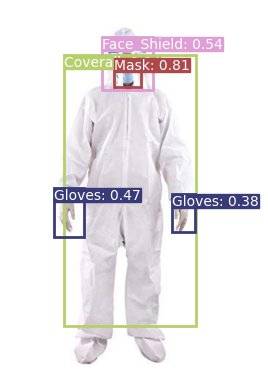

Image data/samples/3.png:
torch.Size([11, 6])
	+ Label: Coverall | Confidence: 0.9501
	+ Label: Mask | Confidence: 0.9286
	+ Label: Coverall | Confidence: 0.8832
	+ Label: Mask | Confidence: 0.7345
	+ Label: Coverall | Confidence: 0.6525
	+ Label: Mask | Confidence: 0.6496
	+ Label: Mask | Confidence: 0.4526
	+ Label: Mask | Confidence: 0.3465
	+ Label: Gloves | Confidence: 0.3432
	+ Label: Coverall | Confidence: 0.3151
	+ Label: Gloves | Confidence: 0.2846


<Figure size 640x480 with 0 Axes>

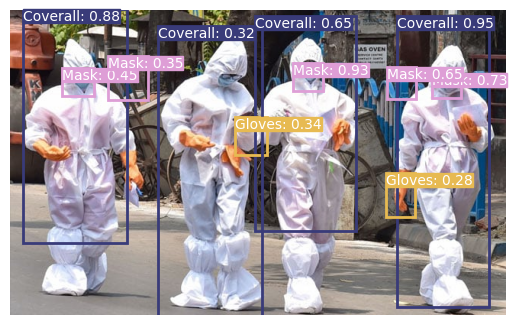

---- Detections were saved to: '/content/drive/MyDrive/output' ----


In [23]:
print_environment_info()
parser = argparse.ArgumentParser(description="Detect objects on images.")
parser.add_argument("-m", "--model", type=str, default="config/yolov3.cfg", help="Path to model definition file (.cfg)")
parser.add_argument("-w", "--weights", type=str, default="/content/drive/MyDrive/checkpoints/yolov3_ckpt_7.pth", help="Path to weights or checkpoint file (.weights or .pth)")
parser.add_argument("-i", "--images", type=str, default="data/samples", help="Path to directory with images to inference")
parser.add_argument("-c", "--classes", type=str, default="data/coco.names", help="Path to classes label file (.names)")
parser.add_argument("-o", "--output", type=str, default="/content/drive/MyDrive/output", help="Path to output directory")
parser.add_argument("-b", "--batch_size", type=int, default=1, help="Size of each image batch")
parser.add_argument("--img_size", type=int, default=416, help="Size of each image dimension for yolo")
parser.add_argument("--n_cpu", type=int, default=8, help="Number of cpu threads to use during batch generation")
parser.add_argument("--conf_thres", type=float, default=0.25, help="Object confidence threshold")
parser.add_argument("--nms_thres", type=float, default=0.4, help="IOU threshold for non-maximum suppression")
args = parser.parse_args(args=[])
print(f"Command line arguments: {args}")

# Extract class names from file
classes = load_classes(args.classes)  # List of class names

img_detections = detect_directory(
    args.model,
    args.weights,
    args.images,
    classes,
    args.output,
    batch_size=args.batch_size,
    img_size=args.img_size,
    n_cpu=args.n_cpu,
    conf_thres=args.conf_thres,
    nms_thres=args.nms_thres)